# Exploratory Data Analysis and Prediction using Data Modeling of Healthcare Insurance Data

## Problem Statement

Businesses, particularly insurance companies, heavily rely on customer data. By understanding demographic information such as age, gender, and location, they can make informed business decisions that enhance their operations and customer satisfaction.

## Dataset Overview

This comprehensive dataset provides valuable insights into the impact of personal characteristics on medical insurance premiums. It enables researchers and analysts to explore the influence of factors such as age, gender, weight, family size, and smoking habits on insurance pricing. Furthermore, the dataset facilitates the development of predictive models that can forecast healthcare expenses.

Each field within the dataset is defined as follows:

- **Age:** The age of the insured individual.

- **Sex:** The gender of the insured (male or female).

- **BMI (Body Mass Index):** A standardized measure of body fat calculated based on height and weight.

- **Children:** The number of dependents covered under the insurance plan.

- **Smoker:** Indicates whether the insured individual engages in smoking (yes or no).

- **Region:** The geographical location within which the insurance coverage is provided.

- **Charges:** The total medical insurance expenses incurred by the insured individual.


## Step Wise Tasks 

1. Import Required Libraries

2. Adjusting Row Column Settings

3. Loading the data Set

4. Exploratory Data Analysis

5. Capturing / Detecting Numeric and Categorical Variables

6. Analysis of Categorical Variables

7. Analysis of Numerical Variables

8. Analysis of Categorical Variables by Target

9. Analysis of Numeric Variables by Target

10. Correlation Analysis

11. Distribution of the Dependent Variable

12. Examining the Logarithm of the Dependent Variable

13. Outliers Analysis

14. Missing Value Analysis

15. Rare Analysis

16. Feature Extraction

17. Encoding

18. Standardization Process

19. Creating Model

20. Hyperparameter optimization

21. Final Model Predictions and Comparison with True Prices

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

import warnings
warnings.simplefilter(action="ignore")

## 2. Adjusting Row Column Settings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 3. Loading the data Set

In [3]:
df = pd.read_csv('/kaggle/input/healthcare-insurance/insurance.csv')

## 4. Exploratory Data Analysis

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_df = df.select_dtypes(include='number')
    # quantile() işlemi
    quantiles = numeric_df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T
    print(quantiles)

In [5]:
check_df(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [6]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.548
1334,18,female,31.920,0,no,northeast,2205.981
1335,18,female,36.850,0,no,southeast,1629.833
1336,21,female,25.800,0,no,southwest,2007.945


## 5. Capturing / Detecting Numeric and Categorical Variables

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [8]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [9]:
cat_cols

['sex', 'smoker', 'region', 'children']

In [10]:
num_cols

['age', 'bmi', 'charges']

In [11]:
cat_but_car

[]

In [12]:
num_but_cat

['children']

In [13]:
num_cols = [col for col in num_cols if col not in "charges"]

In [14]:
num_cols

['age', 'bmi']

## 6. Analysis of Categorical Variables

In [15]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette="Set2")
        plt.xticks(rotation=45)
        plt.show(block=True)

        sex  Ratio
sex               
male    676 50.523
female  662 49.477
##########################################


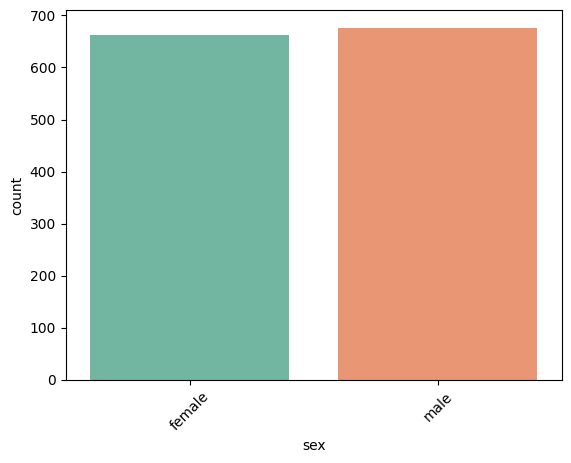

        smoker  Ratio
smoker               
no        1064 79.522
yes        274 20.478
##########################################


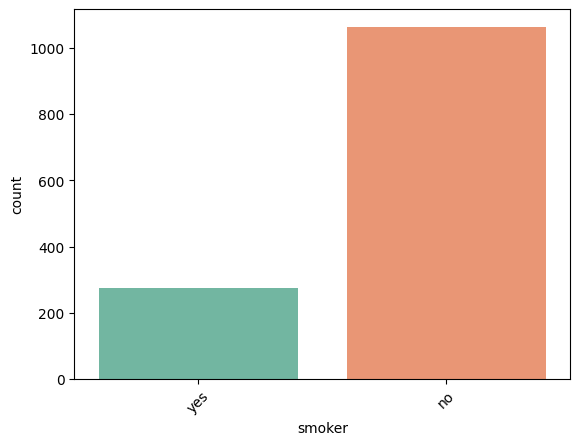

           region  Ratio
region                  
southeast     364 27.205
southwest     325 24.290
northwest     325 24.290
northeast     324 24.215
##########################################


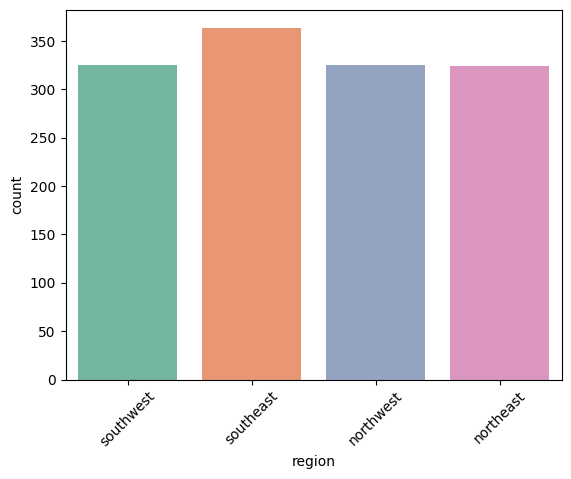

          children  Ratio
children                 
0              574 42.900
1              324 24.215
2              240 17.937
3              157 11.734
4               25  1.868
5               18  1.345
##########################################


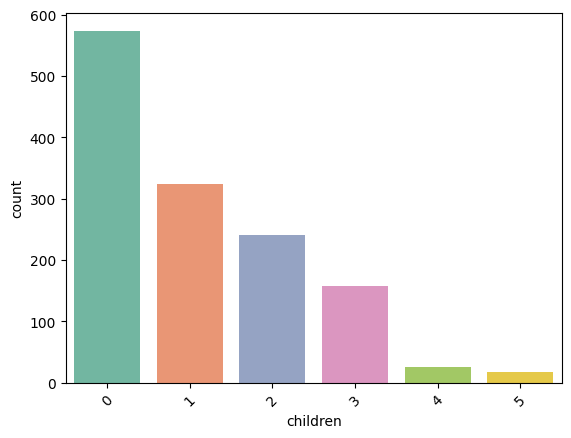

In [16]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

## 7. Analysis of Numerical Variables

In [17]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        sns.histplot(data=dataframe, x=col_name, bins=20, kde=True, color="blue")
        plt.xticks(rotation=45)
        plt.show(block=True)

count   1338.000
mean      39.207
std       14.050
min       18.000
5%        18.000
10%       19.000
20%       24.000
30%       29.000
40%       34.000
50%       39.000
60%       44.000
70%       49.000
80%       54.000
90%       59.000
95%       62.000
99%       64.000
max       64.000
Name: age, dtype: float64


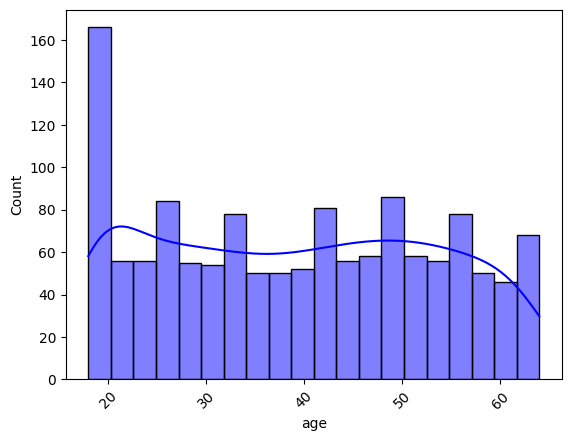

count   1338.000
mean      30.663
std        6.098
min       15.960
5%        21.256
10%       22.990
20%       25.326
30%       27.360
40%       28.797
50%       30.400
60%       32.032
70%       33.660
80%       35.860
90%       38.619
95%       41.106
99%       46.408
max       53.130
Name: bmi, dtype: float64


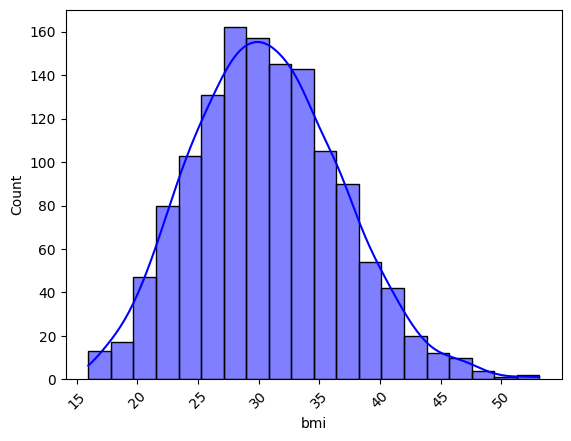

In [18]:
for col in num_cols:
    num_summary(df, col, plot=True)

## 8. Analysis of Categorical Variables by Target

In [19]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe, palette="Set2")
        plt.xticks(rotation=45)
        plt.show(block=True)

        TARGET_MEAN
sex                
female    12569.579
male      13956.751




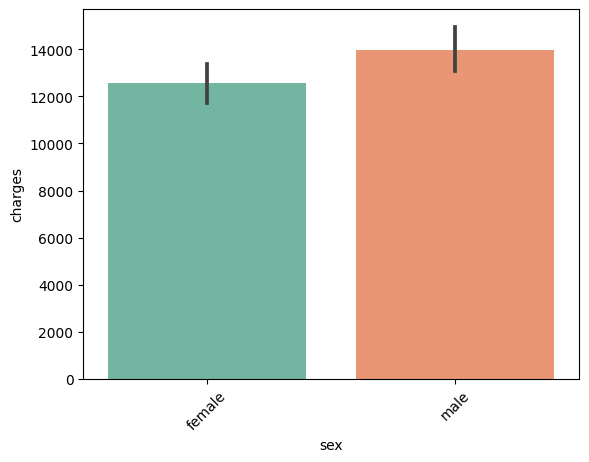

        TARGET_MEAN
smoker             
no         8434.268
yes       32050.232




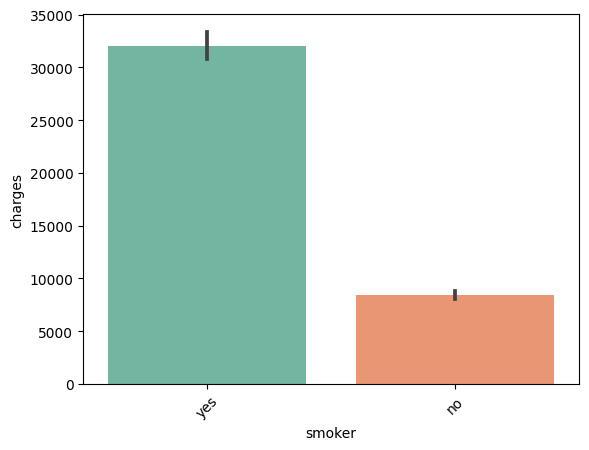

           TARGET_MEAN
region                
northeast    13406.385
northwest    12417.575
southeast    14735.411
southwest    12346.937




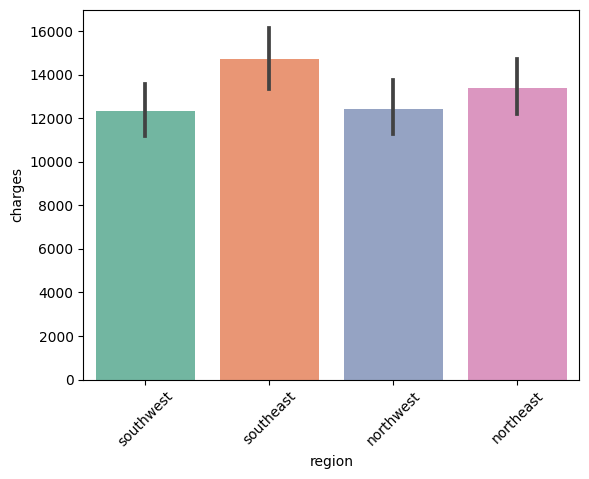

          TARGET_MEAN
children             
0           12365.976
1           12731.172
2           15073.564
3           15355.318
4           13850.656
5            8786.035




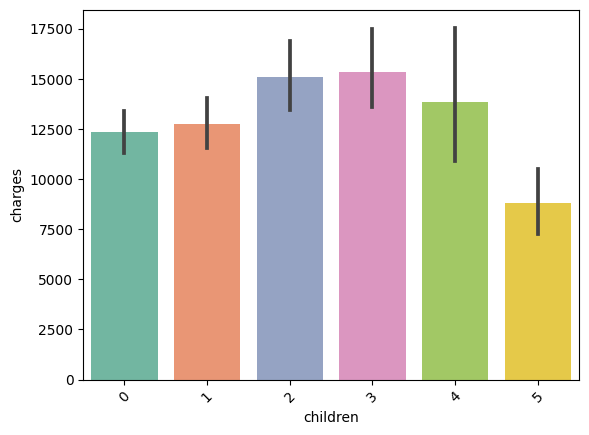

In [20]:
for col in cat_cols:
    target_summary_with_cat(df, "charges", col, plot=True)

## 9. Analysis of Numeric Variables by Target

In [21]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

In [22]:
for col in num_cols:
    target_summary_with_num(df, "charges", col, plot=False)

           age_mean
charges            
1121.874     18.000
1131.507     18.000
1135.941     18.000
1136.399     18.000
1137.011     18.000
...             ...
55135.402    33.000
58571.074    31.000
60021.399    52.000
62592.873    45.000
63770.428    54.000

[1337 rows x 1 columns]


           bmi_mean
charges            
1121.874     23.210
1131.507     30.140
1135.941     33.330
1136.399     33.660
1137.011     34.100
...             ...
55135.402    35.530
58571.074    38.095
60021.399    34.485
62592.873    30.360
63770.428    47.410

[1337 rows x 1 columns]




## 10. Correlation Analysis

In [23]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Only numerical columns
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Correlation matrix
    corr = numeric_df.corr()
    cor_matrix = corr.abs()

    # Select upper triangular matrix (to remove unnecessary repetitions)
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Let's select the column pairs whose correlation is higher than the threshold
    high_corrs = [(col, row)
                  for col in cor_matrix.columns
                  for row in cor_matrix.index
                  if not pd.isna(upper_triangle_matrix.loc[row, col]) and abs(
            upper_triangle_matrix.loc[row, col]) > corr_th]

    if plot:
        # Heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu")
        plt.title("Correlation Heat Map")
        plt.show()

    return high_corrs

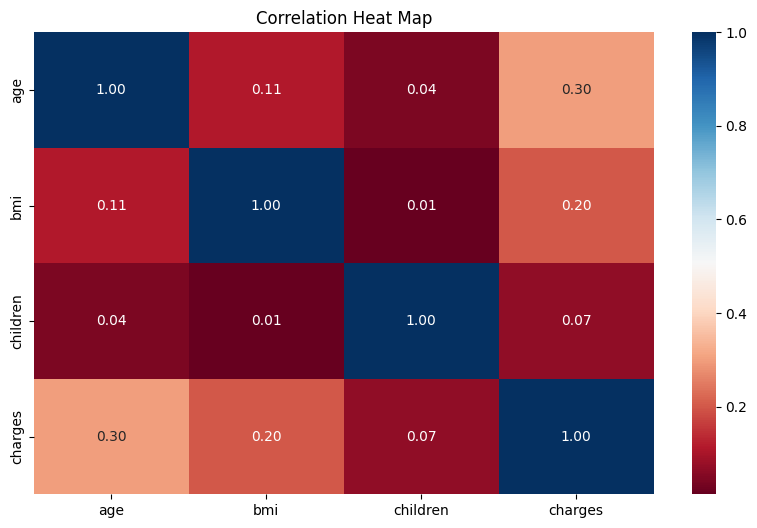

[]

In [24]:
high_correlated_cols(df, plot=True)

In [25]:
selected_cols = num_cols + ['charges']
selected_df = df[selected_cols]
corr_matrix = selected_df.corr()

In [26]:
corr_matrix

,age,bmi,charges
age,1.000,0.109,0.299
bmi,0.109,1.000,0.198
charges,0.299,0.198,1.000


## 11. Distribution of the Dependent Variable

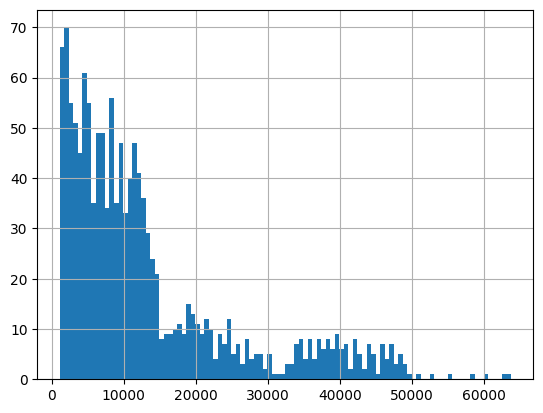

In [27]:
df["charges"].hist(bins=100)
plt.show(block=True)

## 12. Examining the Logarithm of the Dependent Variable

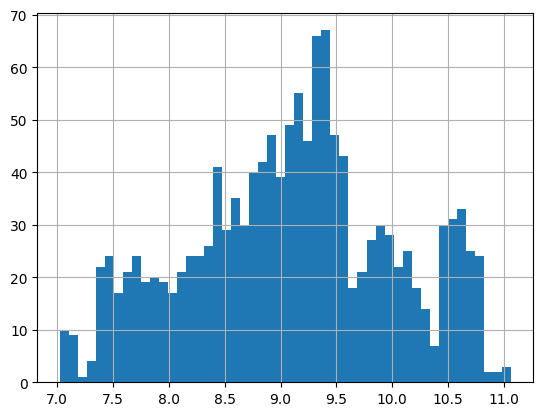

In [28]:
np.log1p(df['charges']).hist(bins=50)
plt.show(block=True)

## 13. Outliers Analysis

In [29]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [30]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [31]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi False


## 14. Missing Value Analysis

In [32]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [33]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 15. Rare Analysis

In [34]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({'COUNT': dataframe[col].value_counts(),
                            'RATIO': dataframe[col].value_counts() / len(dataframe),
                            'TARGET_MEAN': dataframe.groupby(col)[target].mean()}), end='\n\n\n')

In [35]:
rare_analyser(df, "charges", cat_cols)

sex : 2
        COUNT  RATIO  TARGET_MEAN
sex                              
female    662  0.495    12569.579
male      676  0.505    13956.751


smoker : 2
        COUNT  RATIO  TARGET_MEAN
smoker                           
no       1064  0.795     8434.268
yes       274  0.205    32050.232


region : 4
           COUNT  RATIO  TARGET_MEAN
region                              
northeast    324  0.242    13406.385
northwest    325  0.243    12417.575
southeast    364  0.272    14735.411
southwest    325  0.243    12346.937


children : 6
          COUNT  RATIO  TARGET_MEAN
children                           
0           574  0.429    12365.976
1           324  0.242    12731.172
2           240  0.179    15073.564
3           157  0.117    15355.318
4            25  0.019    13850.656
5            18  0.013     8786.035




In [36]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

In [37]:
rare_encoder(df, 0.01)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.548
1334,18,female,31.920,0,no,northeast,2205.981
1335,18,female,36.850,0,no,southeast,1629.833
1336,21,female,25.800,0,no,southwest,2007.945


## 16. Feature Extraction

In [38]:
# 1. first male
male_condition = df['sex'] == 'male'
df.loc[male_condition, 'AGE_GROUP'] = pd.cut(
    df.loc[male_condition, 'age'],
    bins=[0, 40, 60, 100],
    labels=["Young_Adults_Male", "Middle-Aged_Adults_Male", "Old_Adults_Male"],
    right=False
)

# 2. Categoric to str
df['AGE_GROUP'] = df['AGE_GROUP'].astype(str)

# 3. Fill NaN with woman
female_condition = df['sex'] == 'female'
df.loc[female_condition, 'AGE_GROUP'] = pd.cut(
    df.loc[female_condition, 'age'],
    bins=[0, 40, 60, 100],
    labels=["Young_Adults_Female", "Middle-Aged_Adults_Female", "Old_Adults_Female"],
    right=False
).astype(str)  # to str

In [39]:
df['NEW_BMI'] = pd.cut(x=df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese",]).astype(str)

In [40]:
df["NEW_AGE_BMI_NOM"] = df["NEW_BMI"] + df["AGE_GROUP"]

In [41]:
# 1. RISKY: Those who both smoke and are overweight/obese
df['risk_high'] = ((df['smoker'] == "yes") &
              (df['NEW_BMI'].isin(['Overweight', 'Obese_1', 'Obese_2', 'Obese_3']))).astype(int)

# 2. RISK: Only overweight/obese (including non-smokers)
df['risk_medium'] = df['NEW_BMI'].isin(['Overweight', 'Obese_1', 'Obese_2', 'Obese_3']).astype(int)

In [42]:
df["risk_score"] = df["risk_high"] * 50 + df["risk_medium"] * 25 + df["age"]

In [43]:
df['risk_group'] = pd.qcut(x=df['risk_score'], q=4,
                       labels=["no_risk", "medium_risky", "high_risky", "very_high_risky"]).astype(str)

In [44]:
df['bmi_age_ratio'] = df['bmi'] / df['age']
df['children_smoker'] = df['children'] * df['smoker'].map({'yes': 1, 'no': 0})

In [45]:
df['age_squared'] = df['age'] ** 2
df['bmi_cubed'] = df['bmi'] ** 3

In [46]:
df.columns = [col.upper() for col in df.columns]

In [47]:
df.head()

,AGE,SEX,BMI,CHILDREN,SMOKER,REGION,CHARGES,AGE_GROUP,NEW_BMI,NEW_AGE_BMI_NOM,RISK_HIGH,RISK_MEDIUM,RISK_SCORE,RISK_GROUP,BMI_AGE_RATIO,CHILDREN_SMOKER,AGE_SQUARED,BMI_CUBED
0,19,female,27.900,0,yes,southwest,16884.924,Young_Adults_Female,Overweight,OverweightYoung_Adults_Female,1,1,94,very_high_risky,1.468,0,361,21717.639
1,18,male,33.770,1,no,southeast,1725.552,Young_Adults_Male,Obese,ObeseYoung_Adults_Male,0,0,18,no_risk,1.876,0,324,38511.744
2,28,male,33.000,3,no,southeast,4449.462,Young_Adults_Male,Obese,ObeseYoung_Adults_Male,0,0,28,no_risk,1.179,0,784,35937.000
3,33,male,22.705,0,no,northwest,21984.471,Young_Adults_Male,Healthy,HealthyYoung_Adults_Male,0,0,33,medium_risky,0.688,0,1089,11704.814
4,32,male,28.880,0,no,northwest,3866.855,Young_Adults_Male,Overweight,OverweightYoung_Adults_Male,0,1,57,high_risky,0.902,0,1024,24087.491


## 17. Encoding

In [48]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 1338
Variables: 18
cat_cols: 10
num_cols: 7
cat_but_car: 1
num_but_cat: 4


In [49]:
cat_cols

['SEX',
 'SMOKER',
 'REGION',
 'AGE_GROUP',
 'NEW_BMI',
 'RISK_GROUP',
 'CHILDREN',
 'RISK_HIGH',
 'RISK_MEDIUM',
 'CHILDREN_SMOKER']

In [50]:
num_cols

['AGE',
 'BMI',
 'CHARGES',
 'RISK_SCORE',
 'BMI_AGE_RATIO',
 'AGE_SQUARED',
 'BMI_CUBED']

In [51]:
cat_but_car

['NEW_AGE_BMI_NOM']

In [52]:
num_but_cat

['CHILDREN', 'RISK_HIGH', 'RISK_MEDIUM', 'CHILDREN_SMOKER']

In [53]:
cat_cols = cat_cols + cat_but_car

In [54]:
cat_cols

['SEX',
 'SMOKER',
 'REGION',
 'AGE_GROUP',
 'NEW_BMI',
 'RISK_GROUP',
 'CHILDREN',
 'RISK_HIGH',
 'RISK_MEDIUM',
 'CHILDREN_SMOKER',
 'NEW_AGE_BMI_NOM']

In [55]:
# Label Encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [56]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [57]:
binary_cols

['SEX', 'SMOKER']

In [58]:
for col in binary_cols:
    df = label_encoder(df, col)

In [59]:
df.head()

,AGE,SEX,BMI,CHILDREN,SMOKER,REGION,CHARGES,AGE_GROUP,NEW_BMI,NEW_AGE_BMI_NOM,RISK_HIGH,RISK_MEDIUM,RISK_SCORE,RISK_GROUP,BMI_AGE_RATIO,CHILDREN_SMOKER,AGE_SQUARED,BMI_CUBED
0,19,0,27.900,0,1,southwest,16884.924,Young_Adults_Female,Overweight,OverweightYoung_Adults_Female,1,1,94,very_high_risky,1.468,0,361,21717.639
1,18,1,33.770,1,0,southeast,1725.552,Young_Adults_Male,Obese,ObeseYoung_Adults_Male,0,0,18,no_risk,1.876,0,324,38511.744
2,28,1,33.000,3,0,southeast,4449.462,Young_Adults_Male,Obese,ObeseYoung_Adults_Male,0,0,28,no_risk,1.179,0,784,35937.000
3,33,1,22.705,0,0,northwest,21984.471,Young_Adults_Male,Healthy,HealthyYoung_Adults_Male,0,0,33,medium_risky,0.688,0,1089,11704.814
4,32,1,28.880,0,0,northwest,3866.855,Young_Adults_Male,Overweight,OverweightYoung_Adults_Male,0,1,57,high_risky,0.902,0,1024,24087.491


In [60]:
# One-Hot Encoding

cat_cols = [col for col in cat_cols if col not in binary_cols]

In [61]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [62]:
df = one_hot_encoder(df, cat_cols)

In [63]:
df.head()

,AGE,SEX,BMI,SMOKER,CHARGES,RISK_SCORE,BMI_AGE_RATIO,AGE_SQUARED,BMI_CUBED,REGION_northeast,REGION_northwest,REGION_southeast,REGION_southwest,AGE_GROUP_Middle-Aged_Adults_Female,AGE_GROUP_Middle-Aged_Adults_Male,AGE_GROUP_Old_Adults_Female,AGE_GROUP_Old_Adults_Male,AGE_GROUP_Young_Adults_Female,AGE_GROUP_Young_Adults_Male,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight,RISK_GROUP_high_risky,RISK_GROUP_medium_risky,RISK_GROUP_no_risk,RISK_GROUP_very_high_risky,CHILDREN_0,CHILDREN_1,CHILDREN_2,CHILDREN_3,CHILDREN_4,CHILDREN_5,RISK_HIGH_0,RISK_HIGH_1,RISK_MEDIUM_0,RISK_MEDIUM_1,CHILDREN_SMOKER_0,CHILDREN_SMOKER_1,CHILDREN_SMOKER_2,CHILDREN_SMOKER_3,CHILDREN_SMOKER_4,CHILDREN_SMOKER_5,NEW_AGE_BMI_NOM_HealthyMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_HealthyMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_HealthyOld_Adults_Female,NEW_AGE_BMI_NOM_HealthyOld_Adults_Male,NEW_AGE_BMI_NOM_HealthyYoung_Adults_Female,NEW_AGE_BMI_NOM_HealthyYoung_Adults_Male,NEW_AGE_BMI_NOM_ObeseMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_ObeseMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_ObeseOld_Adults_Female,NEW_AGE_BMI_NOM_ObeseOld_Adults_Male,NEW_AGE_BMI_NOM_ObeseYoung_Adults_Female,NEW_AGE_BMI_NOM_ObeseYoung_Adults_Male,NEW_AGE_BMI_NOM_OverweightMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_OverweightMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_OverweightOld_Adults_Female,NEW_AGE_BMI_NOM_OverweightOld_Adults_Male,NEW_AGE_BMI_NOM_OverweightYoung_Adults_Female,NEW_AGE_BMI_NOM_OverweightYoung_Adults_Male,NEW_AGE_BMI_NOM_UnderweightMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_UnderweightMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_UnderweightOld_Adults_Female,NEW_AGE_BMI_NOM_UnderweightYoung_Adults_Female,NEW_AGE_BMI_NOM_UnderweightYoung_Adults_Male
0,19,0,27.900,1,16884.924,94,1.468,361,21717.639,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,18,1,33.770,0,1725.552,18,1.876,324,38511.744,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,28,1,33.000,0,4449.462,28,1.179,784,35937.000,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,33,1,22.705,0,21984.471,33,0.688,1089,11704.814,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,32,1,28.880,0,3866.855,57,0.902,1024,24087.491,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


## 18. Standardization Process

In [64]:
num_cols = [col for col in num_cols if col not in ["CHARGES"]]

In [65]:
scaler = RobustScaler()

In [66]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [67]:
df.head(10)

,AGE,SEX,BMI,SMOKER,CHARGES,RISK_SCORE,BMI_AGE_RATIO,AGE_SQUARED,BMI_CUBED,REGION_northeast,REGION_northwest,REGION_southeast,REGION_southwest,AGE_GROUP_Middle-Aged_Adults_Female,AGE_GROUP_Middle-Aged_Adults_Male,AGE_GROUP_Old_Adults_Female,AGE_GROUP_Old_Adults_Male,AGE_GROUP_Young_Adults_Female,AGE_GROUP_Young_Adults_Male,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight,RISK_GROUP_high_risky,RISK_GROUP_medium_risky,RISK_GROUP_no_risk,RISK_GROUP_very_high_risky,CHILDREN_0,CHILDREN_1,CHILDREN_2,CHILDREN_3,CHILDREN_4,CHILDREN_5,RISK_HIGH_0,RISK_HIGH_1,RISK_MEDIUM_0,RISK_MEDIUM_1,CHILDREN_SMOKER_0,CHILDREN_SMOKER_1,CHILDREN_SMOKER_2,CHILDREN_SMOKER_3,CHILDREN_SMOKER_4,CHILDREN_SMOKER_5,NEW_AGE_BMI_NOM_HealthyMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_HealthyMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_HealthyOld_Adults_Female,NEW_AGE_BMI_NOM_HealthyOld_Adults_Male,NEW_AGE_BMI_NOM_HealthyYoung_Adults_Female,NEW_AGE_BMI_NOM_HealthyYoung_Adults_Male,NEW_AGE_BMI_NOM_ObeseMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_ObeseMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_ObeseOld_Adults_Female,NEW_AGE_BMI_NOM_ObeseOld_Adults_Male,NEW_AGE_BMI_NOM_ObeseYoung_Adults_Female,NEW_AGE_BMI_NOM_ObeseYoung_Adults_Male,NEW_AGE_BMI_NOM_OverweightMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_OverweightMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_OverweightOld_Adults_Female,NEW_AGE_BMI_NOM_OverweightOld_Adults_Male,NEW_AGE_BMI_NOM_OverweightYoung_Adults_Female,NEW_AGE_BMI_NOM_OverweightYoung_Adults_Male,NEW_AGE_BMI_NOM_UnderweightMiddle-Aged_Adults_Female,NEW_AGE_BMI_NOM_UnderweightMiddle-Aged_Adults_Male,NEW_AGE_BMI_NOM_UnderweightOld_Adults_Female,NEW_AGE_BMI_NOM_UnderweightYoung_Adults_Female,NEW_AGE_BMI_NOM_UnderweightYoung_Adults_Male
0,-0.833,0,-0.298,1,16884.924,1.621,1.320,-0.620,-0.270,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,-0.875,1,0.401,0,1725.552,-1.000,2.103,-0.639,0.442,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,-0.458,1,0.310,0,4449.462,-0.655,0.763,-0.394,0.333,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,-0.250,1,-0.916,0,21984.471,-0.483,-0.179,-0.231,-0.695,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,-0.292,1,-0.181,0,3866.855,0.345,0.233,-0.265,-0.170,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,-0.333,0,-0.555,0,3756.622,0.310,0.094,-0.299,-0.468,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

## 19. Creating Model

In [68]:
df['LOG_CHARGES'] = np.log1p(df['CHARGES'])

In [69]:
y = df["CHARGES"]

In [70]:
X = df.drop(["LOG_CHARGES", "CHARGES"], axis=1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [72]:
# Model list
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor(n_jobs=1)),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor(n_jobs=1)),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror', n_jobs=1)),
          ("CatBoost", CatBoostRegressor(verbose=False, thread_count=1))]
# Initialize empty lists to store metrics and execution times
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []
model_names = []

# Main loop to fit, predict, and evaluate each model
for name, regressor in models:
    start_time = time.time()

    # Fit the model
    regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = regressor.predict(X_test)

    # Calculate RMSE
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)
    
    # Calculate R^2 score
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate MAE
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    # Store model name
    model_names.append(name)

# Create a DataFrame to hold all the metrics and execution times
results_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R^2 Score': r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'Execution Time (s)': execution_times
})

results_df

,Model,RMSE,R^2 Score,MAE,MSE,Execution Time (s)
0,LR,450238467033571.875,-173963891991061586771968.000,494142944038963.188,27007673556984205755604069777408.000,0.069
1,Ridge,5621.011,0.823,3602.835,27478455.775,0.039
2,Lasso,5627.486,0.824,3565.206,27354363.149,0.318
3,ElasticNet,9061.116,0.457,6995.225,84355792.378,0.041
4,KNN,8434.732,0.535,5082.450,72143059.933,0.095
5,CART,6428.867,0.711,3104.333,44929475.450,0.075
6,RF,4886.466,0.864,2468.905,21146843.568,3.579
7,GBM,4646.659,0.877,2430.412,19161046.862,1.463
8,XGBoost,5242.714,0.846,2823.141,23937990.675,0.747
9,CatBoost,4796.211,0.865,2477.023,21028353.178,7.589


## 20. Hyperparameter optimization

In [73]:
# Initialize lists to store metrics
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []
model_names = []

# Define the hyperparameters for each model

param_grids = {
    'LR': {},
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'KNN': {'n_neighbors': [1, 3, 5, 7, 9]},
    'CART': {'max_depth': [None, 5, 10, 20, 30], 'min_samples_leaf': [1, 2, 3]},
    'RF': {'n_estimators': [10, 30, 50, 70, 100], 'max_depth': [None, 5, 10, 20]},
    'GBM': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    'XGBoost': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    # 'LightGBM': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    'CatBoost': {'iterations': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1], 'depth': [3, 4, 5, 6, 7]}
}

# Variables to store best model and score globally
best_global_score = np.inf
best_global_model = None

# Main loop to fit, predict, and evaluate each model
for name, regressor in models:
    start_time = time.time()
    
    # Hyperparameter tuning with GridSearchCV if param_grids is defined
    if param_grids.get(name):
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = regressor
        best_model.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Update best global model and score
    if rmse < best_global_score:
        best_global_score = rmse
        best_global_model = best_model

    # Calculate other metrics
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate execution time
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    # Store model name
    model_names.append(name)

# Create a DataFrame to store all the metrics and execution times
results_with_tuning_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R^2 Score': r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'Execution Time (s)': execution_times
})

results_with_tuning_df

,Model,RMSE,R^2 Score,MAE,MSE,Execution Time (s)
0,LR,5196890758615598.000,-173963891991061586771968.000,494142944038963.188,27007673556984205755604069777408.000,0.009
1,Ridge,5241.990,0.823,3602.835,27478455.775,1.496
2,Lasso,5296.702,0.819,3704.551,28055056.182,0.380
3,ElasticNet,5257.364,0.822,3664.496,27639875.199,0.802
4,KNN,8237.900,0.563,4679.131,67863002.268,0.148
5,CART,4745.387,0.855,2719.404,22518700.579,0.364
6,RF,4431.187,0.874,2553.127,19635417.801,8.159
7,GBM,4367.706,0.877,2538.541,19076858.882,3.920
8,XGBoost,4438.813,0.873,2465.298,19703064.610,3.484
9,CatBoost,4339.701,0.879,2459.120,18833006.155,16.705


In [74]:
best_global_model

In [75]:
# Final Prediction Model
final_model = best_global_model

# Make predictions on the test set using the final model
y_final_pred = final_model.predict(X_test)
final_y_pred = (y_final_pred)
final_y_test =(y_test)

In [76]:
# Creating DataFrame with predicted and actual values
results = pd.DataFrame({'Predicted Value': final_y_pred, 'True Value': final_y_test})

# Adding the difference between actual and forecasted prices as a new column
results['Difference'] = results['True Value'] - results['Predicted Value']

# Add an absolute difference column
results['Absolute Difference'] = results['Difference'].abs()

# Show the 5 worst predictions (largest to smallest by absolute difference)
print("5 worst predictions:")
print(results.sort_values(by='Absolute Difference', ascending=False).head().drop('Absolute Difference', axis=1))

# Show top 5 predictions (smallest to largest by absolute difference)
print("\ntop 5 predictions:")
print(results.sort_values(by='Absolute Difference').head().drop('Absolute Difference', axis=1))

5 worst predictions:
      Predicted Value  True Value  Difference
806          7679.203   28476.735   20797.532
599         13156.618   33471.972   20315.354
430          2940.365   23082.955   20142.590
543         45017.266   63770.428   18753.162
1039         4059.381   22493.660   18434.279

top 5 predictions:
      Predicted Value  True Value  Difference
1242         4262.286    4296.271      33.985
665         42627.492   42560.430     -67.061
1314        18840.063   18765.875     -74.187
629         42903.285   42983.459      80.174
344         11062.498   10977.206     -85.291


## 21. Final Model Predictions and Comparison with True Prices

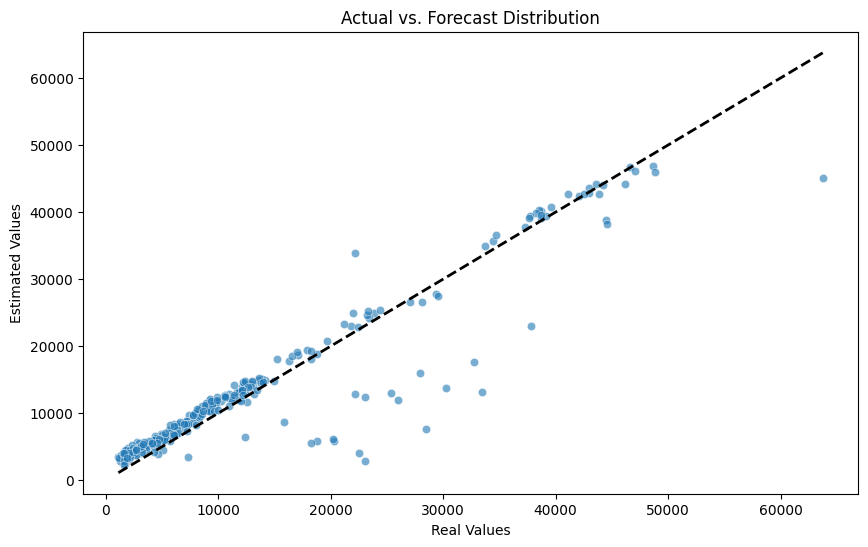

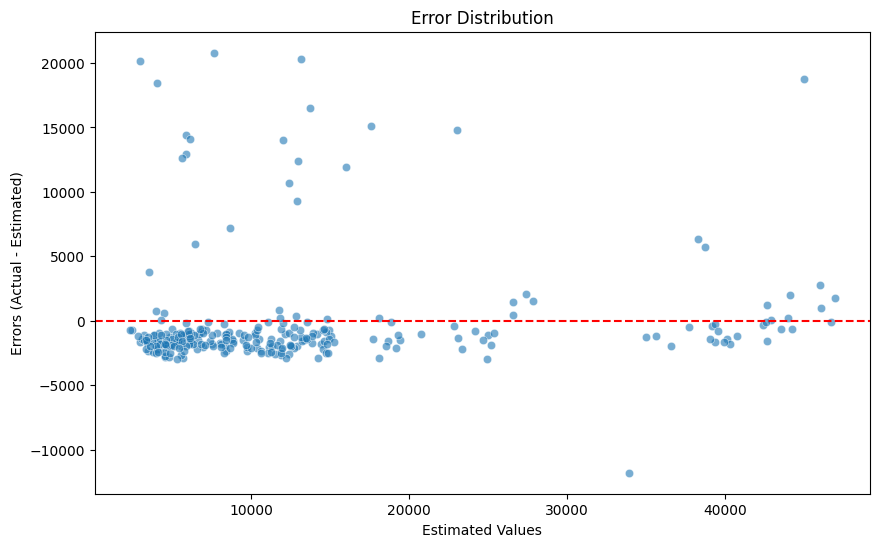

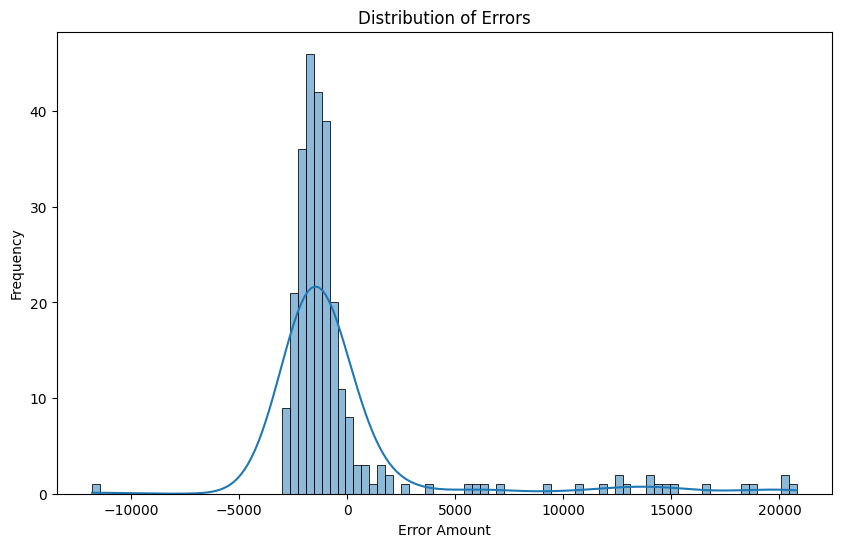

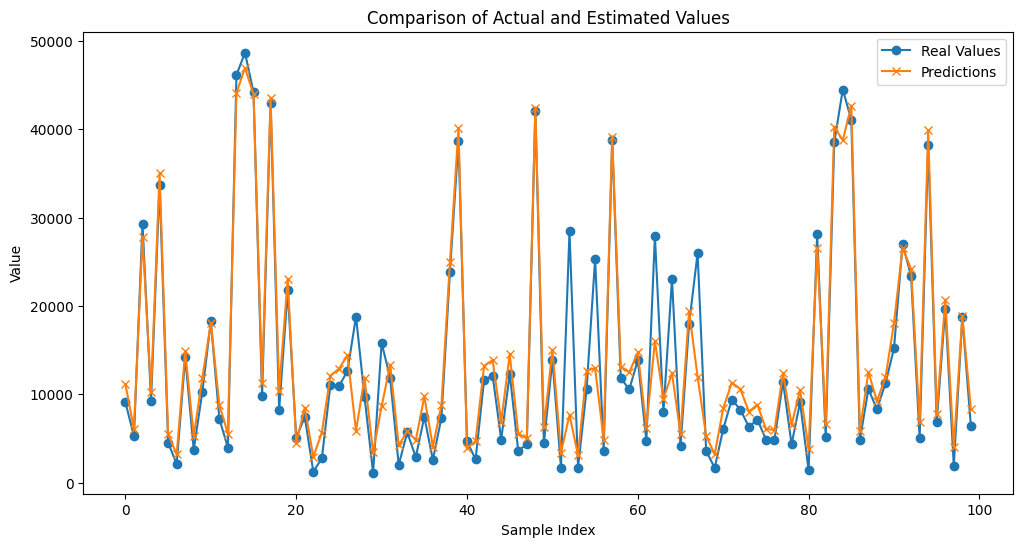

Regression Model Performance Metrics:
RMSE: 4339.7012
MAE: 2459.1195
R² Skoru: 0.8787


In [77]:
# Training the model
best_global_model.fit(X_train, y_train)

# Predictions
y_final_pred = best_global_model.predict(X_test)

# 1. Actual vs. Forecast Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_final_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real Values')
plt.ylabel('Estimated Values')
plt.title('Actual vs. Forecast Distribution')
plt.show()

# 2. Error Distribution Graph (Residual Plot)
residuals = y_test - y_final_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_final_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Estimated Values')
plt.ylabel('Errors (Actual - Estimated)')
plt.title('Error Distribution')
plt.show()

# 3. Error Density Graph
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Error Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.show()

# 4. Comparison of Actual and Estimated Values (First 100 Examples)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Real Values', marker='o')
plt.plot(y_final_pred[:100], label='Predictions', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of Actual and Estimated Values')
plt.legend()
plt.show()

# Performance Metrics
print("Regression Model Performance Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_final_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_final_pred):.4f}")
print(f"R² Skoru: {r2_score(y_test, y_final_pred):.4f}")

## 22. Feature Importance

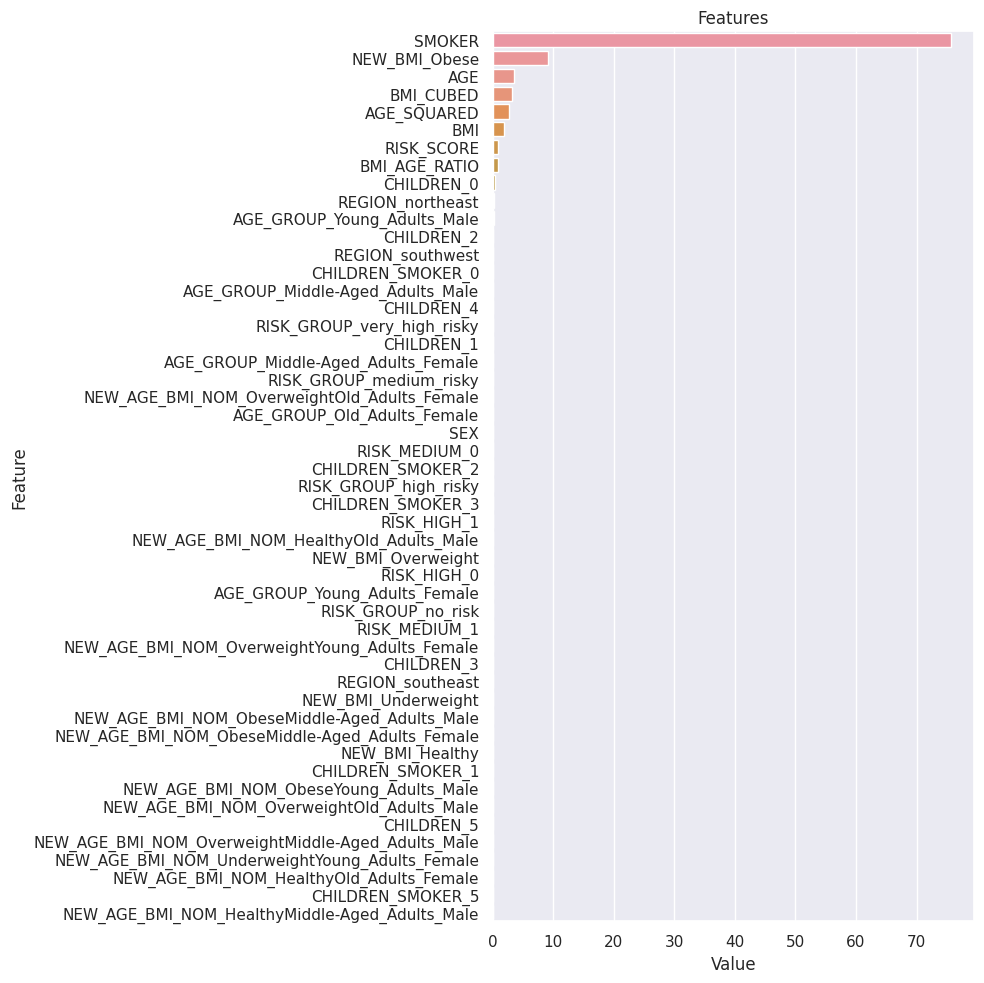

In [78]:
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(final_model, X)